In [2]:
import pandas as pd
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


### Data import and cleaning

In [3]:
file_path = "../data/labels/LABELS_SEED_1.json"
with open(file_path, 'r') as f:
    data = json.load(f)

extracted_data = []
for entry in data:
    seed = entry.get("dataset_title")
    data_title = entry.get("data_title")
    data_units = entry.get("data_units", {})

    for unit in data_units.values():
        labels = unit.get("labels", {})
        objects = labels.get("objects", [])

        polygons = []  
        values = []
        for obj in objects:
            polygons.append(obj.get("polygon"))
            values.append(obj.get("value"))

        if len(polygons) == 0:
            polygons = [None]
            values = [None]
        
        for polygon, value in zip(polygons, values):
            extracted_data.append({
                "seed": seed,
                "data_title": data_title,
                "polygon": polygon,
                "value": value
                })

labels_seed_1 = pd.DataFrame(extracted_data)
labels_seed_1.isna().sum()



seed            0
data_title      0
polygon       114
value         114
dtype: int64

In [4]:
len(labels_seed_1["data_title"].unique())

250

In [5]:
labels_seed_1

,seed,data_title,polygon,value
0,Tiles seed=1,swissimage-dop10_2024_2625.9-1232.8.jpg,None,None
1,Tiles seed=1,swissimage-dop10_2024_2611.1-1238.2.jpg,"{'0': {'x': 0.13877326474668183, 'y': 1}, '1':...",solar_panel
2,Tiles seed=1,swissimage-dop10_2021_2610.2-1149.4.jpg,None,None
3,Tiles seed=1,swissimage-dop10_2021_2708.0-1095.2.jpg,"{'0': {'x': 0.4508513743272538, 'y': 0.6846210...",solar_panel
4,Tiles seed=1,swissimage-dop10_2021_2708.0-1095.2.jpg,"{'0': {'x': 0.644416529442688, 'y': 0.79247189...",solar_panel
...,...,...,...,...
649,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5658760235806427, 'y': 0.9439394...",solar_panel
650,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5393055930823386, 'y': 0.9982774...",solar_panel
651,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5377235997820866, 'y': 0.9987478...",solar_panel
652,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.3972810787641705, 'y': 0.9993728...",solar_panel


The next step is to create the label vectors for each image

In [6]:
def create_segmentation_mask(df, image_size=(1000, 1000), target_value="solar_panel"):
    """
    Create segmentation masks for images with labeled polygons.

    Args:
        df (pd.DataFrame): DataFrame containing `data_title`, `polygon`, and `value`.
        image_size (tuple): Dimensions of the image (width, height).
        target_value (str): Value to filter polygons for masking (e.g., "solar_panel").

    Returns:
        dict: Dictionary with `data_title` as keys and 1D numpy arrays (segmentation masks) as values.
    """
    masks = {}
    
    for _, row in df.iterrows():
        if row['value'] == target_value:
            mask = Image.new("L", image_size, 0)  # "L" mode is for grayscale
            draw = ImageDraw.Draw(mask)
            
            polygon = row['polygon']
            polygon_points = [
                (vertex['x'] * image_size[0], vertex['y'] * image_size[1])
                for vertex in polygon.values()
            ]
            
            # Draw the polygon on the mask
            draw.polygon(polygon_points, outline=1, fill=1)
            mask_array = np.array(mask).flatten()
            
            if row['data_title'] not in masks:
                masks[row['data_title']] = mask_array
            else:
                masks[row['data_title']] = masks[row['data_title']] + mask_array

        else:
            # if no polygon is found, create an empty mask
            masks[row['data_title']] = np.zeros(image_size[0] * image_size[1])

    # Clip the mask values to ensure that they are either 0 or 1 when polygons overlap
    masks = {k: np.clip(v, 0, 1) for k, v in masks.items()}
    return masks

masks_seed_1 = create_segmentation_mask(labels_seed_1)


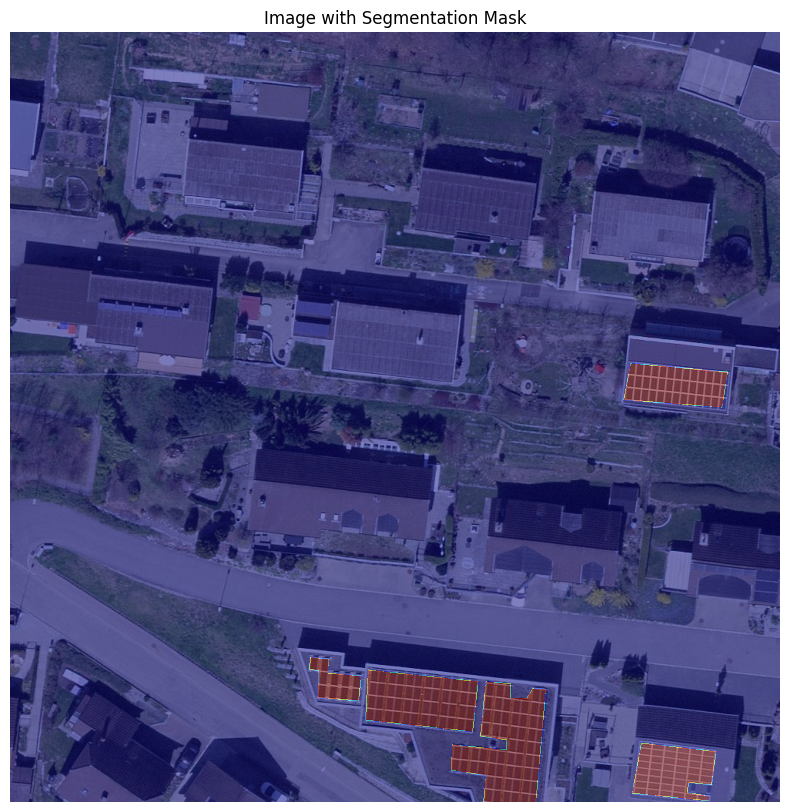

In [7]:
def plot_mask_on_image(image_path, mask, image_size=(1000, 1000), alpha=0.5):
    """
    Plots a segmentation mask on top of an image.

    Args:
        image_path (str): Path to the original image file.
        mask (np.ndarray): 1D numpy array (flattened) representing the segmentation mask.
        image_size (tuple): Dimensions of the image (width, height).
        alpha (float): Transparency level of the mask overlay (0 to 1).
    """
    mask_2d = mask.reshape(image_size)
    image = Image.open(image_path).resize(image_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask_2d, cmap='jet', alpha=alpha) 
    plt.axis('off')
    plt.title("Image with Segmentation Mask")
    plt.show()


empty_image = "swissimage-dop10_2021_2610.0-1149.9.jpg"
filled_image = "swissimage-dop10_2021_2642.9-1226.3.jpg"
empty_image_path = "../data/sample/"+ empty_image
filled_image_path = "../data/sample/"+ filled_image

segmentation_mask = masks_seed_1[filled_image]
plot_mask_on_image(filled_image_path, segmentation_mask)
